In [1]:
import pyarrow.parquet
import os
import pandas as pd
import geopandas as gpd
import glob
from shapely.geometry import Point, LineString
from tqdm.auto import tqdm
import folium
import contextily
import matplotlib.pyplot as plt
import re

Line 1…6 are useless in this dataset, and can be ignored. Points are described in following lines, one for each line.
Field 1: Latitude in decimal degrees.
Field 2: Longitude in decimal degrees.
Field 3: All set to 0 for this dataset.
Field 4: Altitude in feet (-777 if not valid).
Field 5: Date - number of days (with fractional part) that have passed since 12/30/1899.
Field 6: Date as a string.
Field 7: Time as a string.


In [18]:
gpd.options.display_precision = 6  # set display resolution high enaugh
cwd = os.getcwd()
data_dir = os.path.join(cwd, "data")
geolife_dir = os.path.join(data_dir, "users")

# Point per row approach

In [ ]:
def read_points(filename: str):
    df = pd.read_csv(
        os.path.join(geolife_dir, filename), skiprows=6, header=None
    )  # WGS84
    columns = [
        "latitude",
        "longitude",
        "zero",
        "altitude",
        "date",
        "date_str",
        "time",
        "trajectory_id",
    ]
    match = re.search(r"\\(\d+)\.plt$", filename).group(
        1
    )  # get file name to apply to ID
    df["trajectory_id"] = match
    df.rename(columns=dict(zip(df.columns, columns)), inplace=True)
    df.drop(["zero"], inplace=True, axis=1)  # zero column is useless

    df["time"] = df["date_str"] + " " + df["time"]
    df["datetime"] = pd.to_datetime(df["time"], format="%Y-%m-%d %H:%M:%S")

    df["mode"] = "unknown"  # default value
    if os.path.exists(os.path.join(geolife_dir, filename, "..", "..", "labels.txt")):
        labels = pd.read_csv(
            os.path.join(geolife_dir, filename, "..", "..", "labels.txt"),
            sep="\s+",
            skiprows=1,
            header=None,
        )
        labels["start_time"] = pd.to_datetime(labels[0] + " " + labels[1])
        labels["end_time"] = pd.to_datetime(labels[2] + " " + labels[3])
        labels.rename(columns={4: "mode"}, inplace=True)
        labels = labels[["start_time", "end_time", "mode"]]

        for i, row in labels.iterrows():
            mask = (df["datetime"] >= row["start_time"]) & (
                df["datetime"] <= row["end_time"]
            )
            df.loc[mask, "mode"] = row["mode"]

    gdf = gpd.GeoDataFrame(
        df,
        columns=[
            "latitude",
            "longitude",
            "altitude",
            "date",
            "date_str",
            "time",
            "trajectory_id",
            "mode",
        ],
        geometry=gpd.points_from_xy(df["longitude"], df["latitude"]),
        crs="EPSG:4326",
    )

    return gdf


def read_user_points(user_folder, user_name):
    # create geodataframe with user_id as column
    data_folder = os.path.join(user_folder, user_name)
    plt_files = glob.glob(os.path.join(data_folder, "Trajectory", "*.plt"))
    dataframes = []
    for file in plt_files:
        geo_df = read_points(file)
        geo_df["user_id"] = user_name
        dataframes.append(geo_df)
    final_geo_df = pd.concat(dataframes, ignore_index=True)
    return final_geo_df


def read_all_users(folder):
    subfolders = os.listdir(folder)
    dfs = []
    for sf in tqdm(
        subfolders,
        desc="Processing users trajectories",
        colour="cyan",
        smoothing=1.0,
        total=len(subfolders),
    ):
        df = read_user_points(folder, sf)
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    return gpd.GeoDataFrame(df, geometry=df.geometry, crs="EPSG:4326")

In [ ]:
geolife = read_all_users(geolife_dir)

In [ ]:
geolife_preprocessed = geolife[
    ["latitude", "longitude", "altitude", "time", "mode", "trajectory_id", "user_id"]
]
# geolife_preprocessed.to_parquet(os.path.join(data_dir, "geolife.parquet"))

In [19]:
geolife = pd.read_parquet(os.path.join(data_dir, "geolife.parquet"))
geolife["trajectory_id"].nunique()

17784

In [21]:
geolife = gpd.GeoDataFrame(
    geolife,
    geometry=gpd.points_from_xy(geolife["longitude"], geolife["latitude"]),
    crs="EPSG:4326",
)

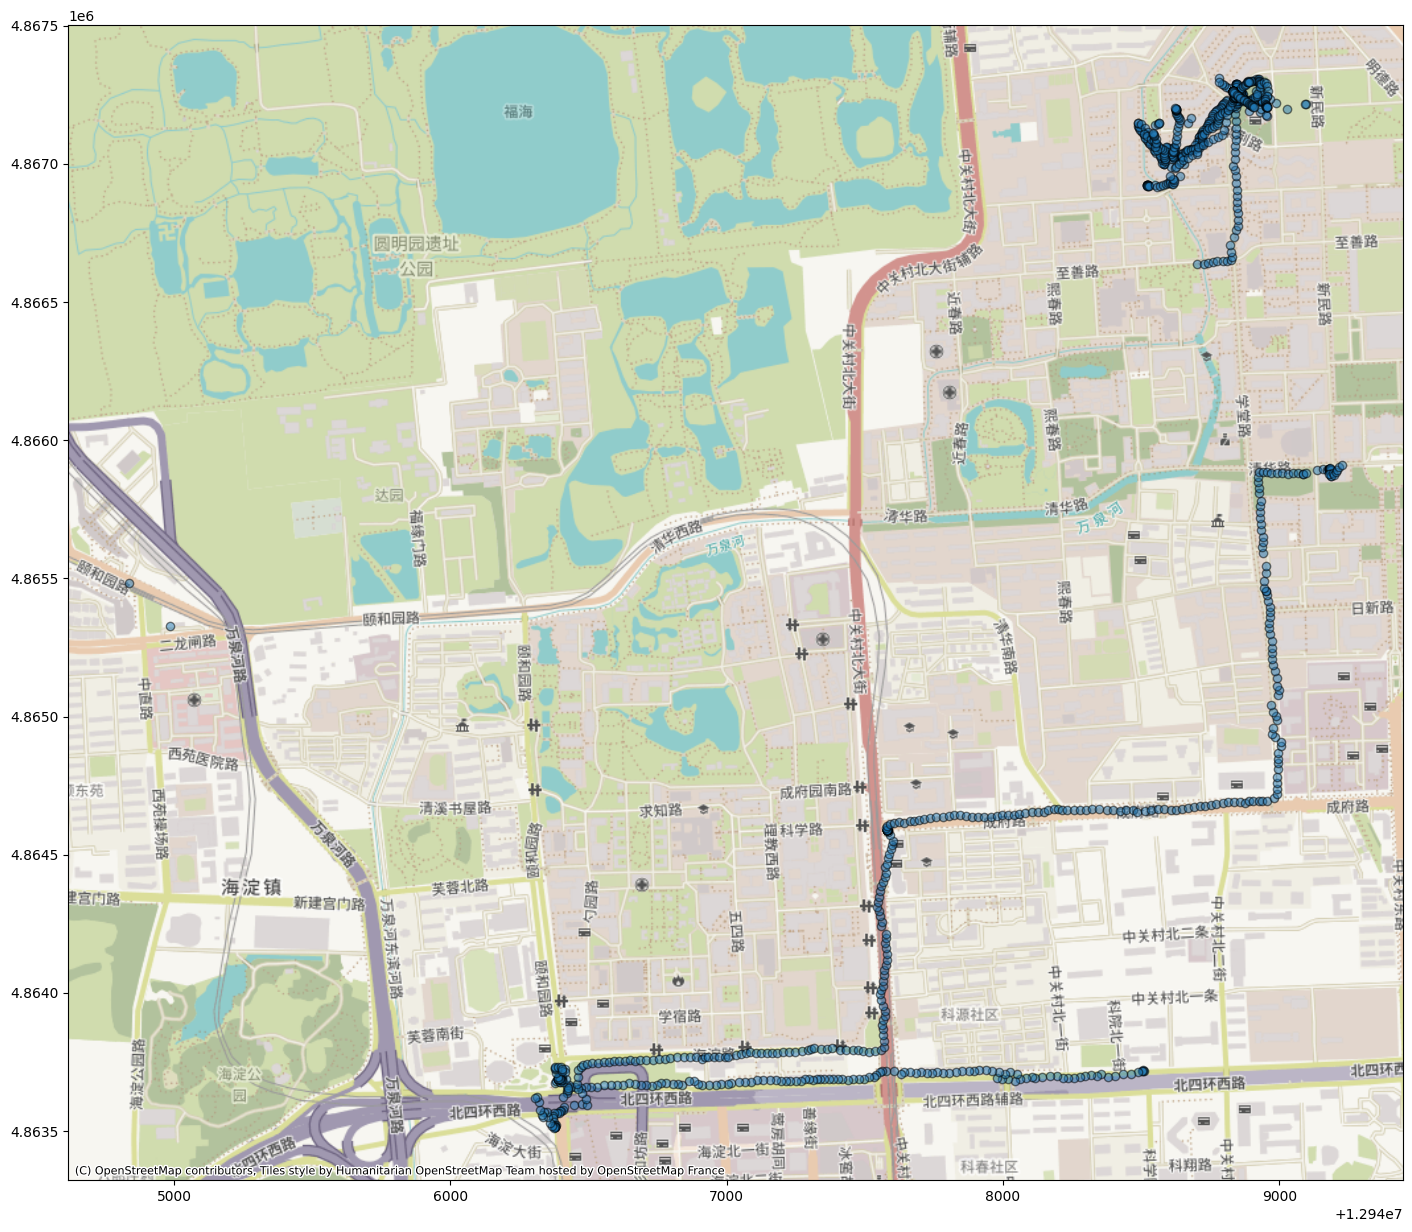

In [23]:
neigh_wm = geolife.iloc[:1000].to_crs(epsg=3857)  # Change crs to web mercator
ax = neigh_wm.plot(figsize=(20, 15), alpha=0.5, edgecolor="k")
contextily.add_basemap(ax, zoom=15)

plt.show()

# Linestring approach

In [4]:
def read_trajectory_labels(filename: str):
    df = pd.read_csv(
        os.path.join(geolife_dir, filename), skiprows=6, header=None
    )  # WGS84
    columns = ["Latitude", "Longitude", "Zero", "Altitude", "Date", "Date_str", "Time"]
    df.rename(columns=dict(zip(df.columns, columns)), inplace=True)
    df["Time"] = df["Date_str"] + " " + df["Time"]
    df["datetime"] = pd.to_datetime(df["Time"], format="%Y-%m-%d %H:%M:%S.%f")
    # Add a 'mode' column to df
    df["mode"] = "unknown"  # default value
    if os.path.exists(os.path.join(geolife_dir, filename, "..", "..", "labels.txt")):
        labels = pd.read_csv(
            os.path.join(geolife_dir, filename, "..", "..", "labels.txt"),
            sep="\s+",
            skiprows=1,
            header=None,
        )
        labels["start_time"] = pd.to_datetime(labels[0] + " " + labels[1])
        labels["end_time"] = pd.to_datetime(labels[2] + " " + labels[3])
        labels.rename(columns={4: "mode"}, inplace=True)
        labels = labels[["start_time", "end_time", "mode"]]

        for i, row in labels.iterrows():
            mask = (df["datetime"] >= row["start_time"]) & (
                df["datetime"] <= row["end_time"]
            )
            df.loc[mask, "mode"] = row["mode"]

    gdf = gpd.GeoDataFrame(
        df,
        columns=columns,
        geometry=gpd.points_from_xy(df["Longitude"], df["Latitude"]),
        crs="EPSG:4326",
    )
    line = LineString(gdf.geometry)
    trajectory_gdf = gpd.GeoDataFrame(geometry=[line], crs="EPSG:4326")
    for col in ["Altitude", "Date", "Time", "Zero", "mode"]:
        trajectory_gdf[col] = [df[col].values.tolist()]
    return trajectory_gdf

In [5]:
filepath2 = os.path.join("021", "Trajectory", "20070429083432.plt")
read_trajectory_labels(filepath2)

geometry  \
0  LINESTRING (116.33035 39.97557, 116.33023 39.9...   

                                            Altitude  \
0  [226.377952755906, 301.837270341207, 328.08398...   

                                                Date  \
0  [39201.3573148148, 39201.3590277778, 39201.523...   

                                                Time  \
0  [2007-04-29 08:34:32, 2007-04-29 08:37:00, 200...   

                                                Zero  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                mode  
0  [unknown, unknown, taxi, taxi, taxi, taxi, tax...

In [6]:
def read_user_linestring(user_folder, user_name):
    # create geodataframe with user_id as column
    data_folder = os.path.join(user_folder, user_name)
    plt_files = glob.glob(os.path.join(data_folder, "Trajectory", "*.plt"))
    dataframes = []
    for file in plt_files:
        geo_df = read_trajectory_labels(file)
        geo_df["user_id"] = user_name
        dataframes.append(geo_df)
    final_geo_df = pd.concat(dataframes, ignore_index=True)
    return final_geo_df

In [7]:
def read_all_users_linestring(folder):
    subfolders = os.listdir(folder)
    dfs = []
    for i, sf in tqdm(
        enumerate(subfolders),
        desc="Processing users trajectories",
        colour="cyan",
        smoothing=1.0,
        total=len(subfolders),
    ):
        df = read_user_linestring(folder, sf)
        dfs.append(df)
    df = pd.concat(dfs, ignore_index=True)
    return gpd.GeoDataFrame(df, geometry=df.geometry, crs="EPSG:4326")

In [ ]:
geolife = read_all_users_linestring(geolife_dir)

In [9]:
geolife.tail()

geometry  \
18665  LINESTRING (116.30535 39.99042, 116.30653 39.9...   
18666  LINESTRING (112.96523 28.16815, 112.97228 28.1...   
18667  LINESTRING (116.30895 39.98547, 116.30972 39.9...   
18668  LINESTRING (116.30278 39.98993, 116.30357 39.9...   
18669  LINESTRING (111.70922 40.91815, 111.70953 40.9...   

                                                Altitude  \
18665  [748.031496062992, 748.031496062992, 721.78477...   
18666  [144.356955380577, 209.97375328084, 209.973753...   
18667  [223.097112860892, 223.097112860892, 223.09711...   
18668  [383.858267716535, 383.858267716535, 383.85826...   
18669  [3825.4593175853, 3809.05511811024, 3795.93175...   

                                                    Date  \
18665  [39475.1867476852, 39475.187662037, 39475.1893...   
18666  [39484.122650463, 39484.1251851852, 39484.1257...   
18667  [39494.3365972222, 39494.3372800926, 39494.337...   
18668  [39495.0427199074, 39495.0432175926, 39495.046...   
18669  [39521.1235532407, 39521.1245833333, 39521.126...   

                                                    Time  \
18665  [2008-01-28 04:28:55, 2008-01-28 04:30:14, 200...   
18666  [2008-02-06 02:56:37, 2008-02-06 03:00:16, 200...   
18667  [2008-02-16 08:04:42, 2008-02-16 08:05:41, 200...   
18668  [2008-02-17 01:01:31, 2008-02-17 01:02:14, 200...   
18669  [2008-03-14 02:57:55, 2008-03-14 02:59:24, 200...   

                                                    Zero  \
18665  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
18666  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
18667  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
18668  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
18669  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   

                                                    mode user_id  
18665  [unknown, unknown, unknown, unknown, unknown, ...     181  
18666  [unknown, unknown, unknown, unknown, unknown, ...     181  
18667  [unknown, unknown, unknown, unknown, unknown, ...     181  
18668  [unknown, unknown, unknown, unknown, unknown, ...     181  
18669  [unknown, unknown, unknown, unknown, unknown, ...     181

In [10]:
geolife.head(25).explore()

In [4]:
geolife = gpd.read_parquet(os.path.join(data_dir, "geolife_linestring.parquet"))

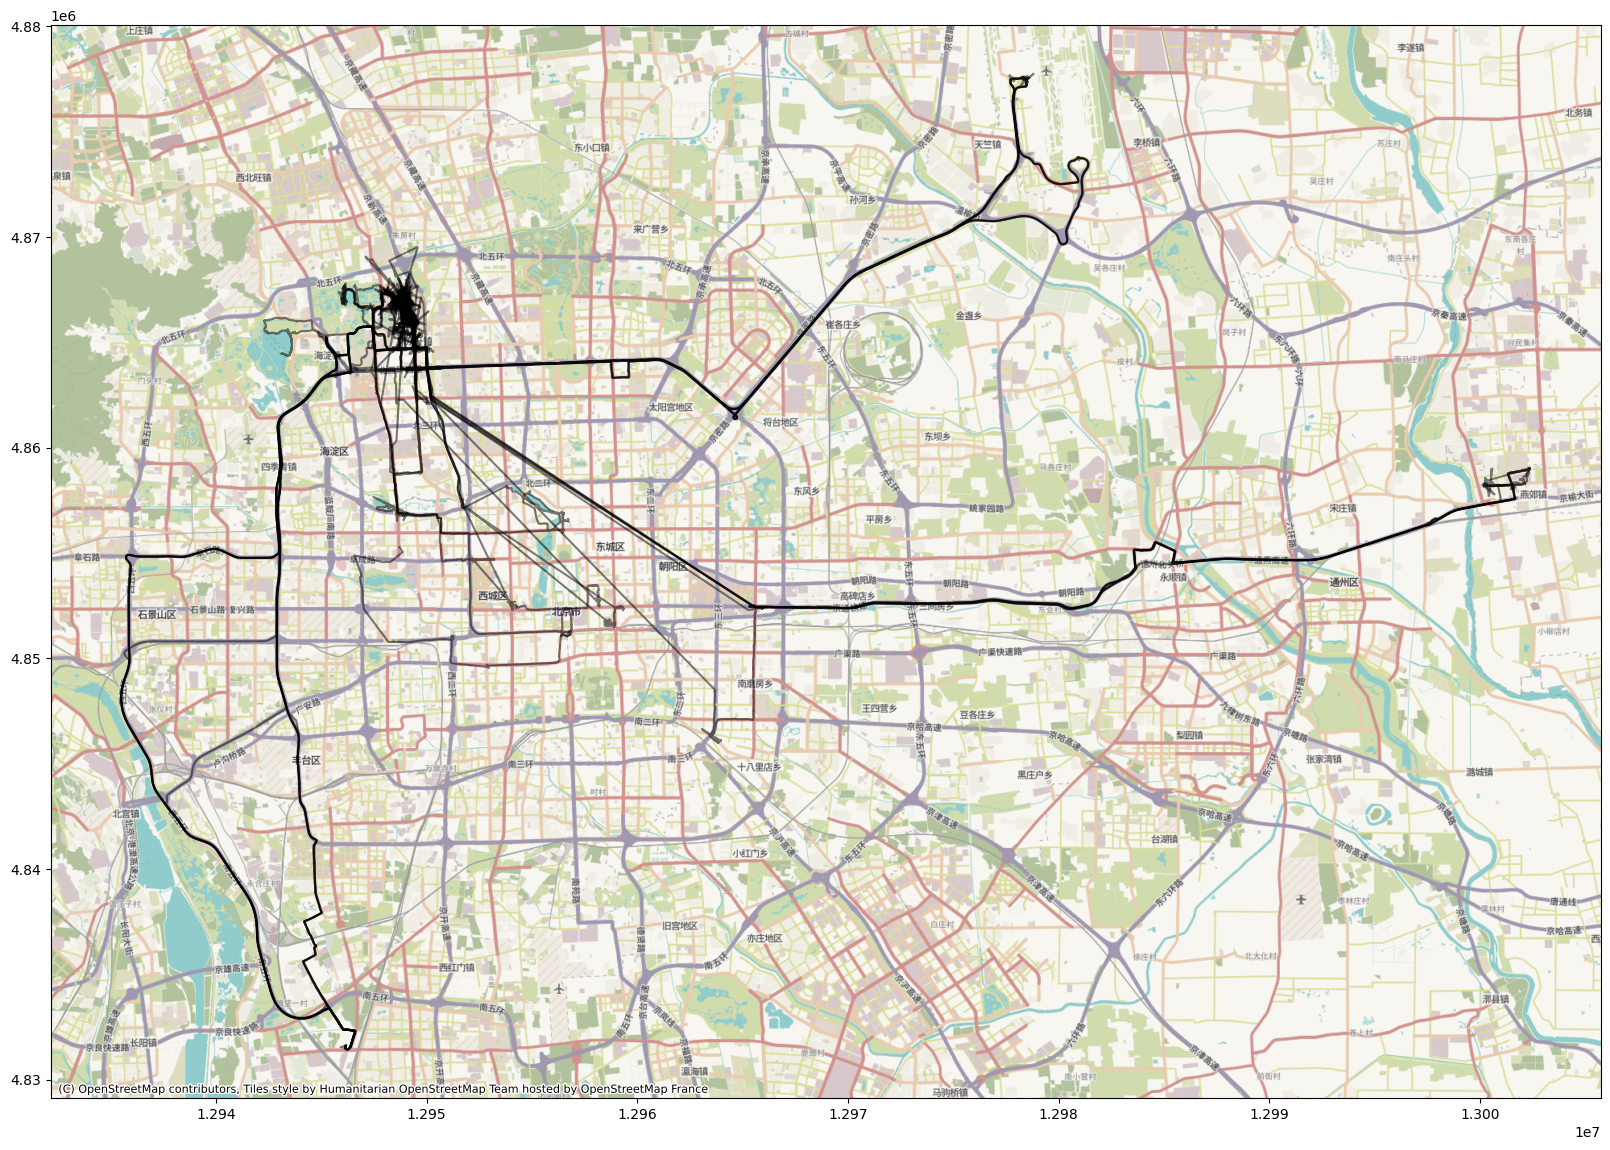

In [17]:
neigh_wm = geolife.iloc[:100].to_crs(epsg=3857)  # change crs to web mercator
ax = neigh_wm.plot(figsize=(20, 15), alpha=0.5, edgecolor="k")
contextily.add_basemap(ax, zoom=12)
plt.savefig(os.path.join(data_dir, "basemap_geolife.png"), dpi=300)
plt.show()